Steane code error correction with  noise
=================================

1. Set up logical zero for Steane code based  on the parity matrix in the book by Nielsen MA, Chuang IL. Quantum Computation and Quantum Information, 10th Anniversary Edition. Cambridge University Press; 2016. p. 474

2. Set up the ancilla

3. Set up the error correction circuit.  There are options to set this circuit up with and without MCT gates.

3. Because of the number of gates in the error correction circuit the error correction process itself produces considerable errors.

Import the necessary function modules, including the SteaneCodeLogicalQubit class.  The methods of this class are called in this notebook.

In [1]:
from qiskit import(
  QuantumCircuit,
  QuantumRegister,
  ClassicalRegister,
  execute,
  Aer
    )

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.compiler import transpile

from circuits import SteaneCodeLogicalQubit

import matplotlib.pyplot as plt
import numpy as np

from helper_functions import (
    count_valid_output_strings,
    find_individual_ancilla_values,
    find_ancilla_values,
    find_parity,
    get_noise,
    mean_of_list,
    calculate_standard_error
    )

Define constants so the process flow can be controlled from one place:

In [2]:
SINGLE_GATE_SET = ['id', 'ry', 'rx']
TWO_GATE_SET = ['rxx']
BASIS_GATE_SET = SINGLE_GATE_SET + TWO_GATE_SET

ERROR_REDUCTION = 1
ITERATIONS = 25
NOISE = True                                              #Test with noise
SHOTS = 10000                                             #Number of shots to run    
MEASURE_NOISE = 0.0046 * ERROR_REDUCTION                  #Measurement noise not relevant
SINGLE_GATE_DEPOLARISING = 0.000366 * ERROR_REDUCTION     #Single gate noise   
TWO_GATE_DEPOLARISING = 0.0204 * ERROR_REDUCTION 

SIMULATOR = Aer.get_backend('qasm_simulator')

Specify the parity check matrix, since this defines the Steane code.  It is validated before the logical qubit is initiated to check that it is orthogonal to the valid codewords.

In [3]:
parity_check_matrix = [[0,0,0,1,1,1,1],
                       [0,1,1,0,0,1,1],
                       [1,0,1,0,1,0,1]]

The allowed codewords for the zero logical from Nielsen and Chuang is stored in a list.  Note, the order of qubits in the list is reversed compared to the normal output of Qiskit.

In [4]:
codewords = [[0,0,0,0,0,0,0],   
             [1,0,1,0,1,0,1],
             [0,1,1,0,0,1,1],
             [1,1,0,0,1,1,0],
             [0,0,0,1,1,1,1],
             [1,0,1,1,0,1,0],
             [0,1,1,1,1,0,0],
             [1,1,0,1,0,0,1]]

Error correction
-----------------------

The error correction circuit is added to the encoding circuit and ancilla and transpiled.  There are two possible circuits, those with Multi Control Toffoli (MCT) gates, and those without.

After error correction we assess the noise

In [5]:
for mct in [False, True]:
    if mct:
        print('With MCT the results are')
    else:
        print('Without MCT the results are')
    simulation_result = []
    for iteration in range(ITERATIONS):
        if mct:
            qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords, extend_ancilla = False)
        else:
            qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords, extend_ancilla = True)
        qubit.set_up_logical_zero()
        qubit.barrier()
        qubit.barrier()
        qubit.set_up_ancilla()
        qubit.barrier()
        if mct:     #Multi Control Toffoli (MCT) gates
            qubit.correct_errors(mct = True)
        else:
            qubit.correct_errors()
        qubit.barrier()
        if NOISE:
            noise_model = get_noise(MEASURE_NOISE, SINGLE_GATE_DEPOLARISING, TWO_GATE_DEPOLARISING,
                                   SINGLE_GATE_SET, TWO_GATE_SET)
        qubit.logical_measure()
        qubit.barrier()
        qt = transpile(qubit, basis_gates = BASIS_GATE_SET)
        if NOISE:
            result = execute(qt, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
        else:
            result = execute(qt, SIMULATOR, shots = SHOTS).result()
        counts = result.get_counts(qt)
        #print ('The different states can be counted.  The simulated result are', counts)
        if mct:
            count_valid, count_invalid = count_valid_output_strings(counts, codewords, 2)
        else:
            count_valid, count_invalid = count_valid_output_strings(counts, codewords, 3)
        error_rate = count_invalid / SHOTS
        simulation_result.append(error_rate)
        print(f'The error rate is {error_rate:.4f} for iteration {iteration}')
    mean = mean_of_list(simulation_result) 
    standard_deviation, standard_error = calculate_standard_error(simulation_result)
    print(f' The average error rate is {mean:.4f}.')
    print(f' The standard deviation is {standard_deviation:.4f}') 
    print(f' The standard error is {standard_error:.4f}')
    print()

Without MCT the results are
The error rate is 0.7017 for iteration 0
The error rate is 0.6958 for iteration 1
The error rate is 0.6953 for iteration 2
The error rate is 0.6932 for iteration 3
The error rate is 0.6997 for iteration 4
The error rate is 0.6891 for iteration 5
The error rate is 0.6920 for iteration 6
The error rate is 0.6923 for iteration 7
The error rate is 0.7053 for iteration 8
The error rate is 0.6860 for iteration 9
The error rate is 0.6941 for iteration 10
The error rate is 0.6933 for iteration 11
The error rate is 0.6898 for iteration 12
The error rate is 0.6908 for iteration 13
The error rate is 0.6919 for iteration 14
The error rate is 0.6983 for iteration 15
The error rate is 0.6971 for iteration 16
The error rate is 0.6939 for iteration 17
The error rate is 0.7006 for iteration 18
The error rate is 0.6880 for iteration 19
The error rate is 0.6975 for iteration 20
The error rate is 0.6966 for iteration 21
The error rate is 0.6861 for iteration 22
The error rate i

Draw circuit

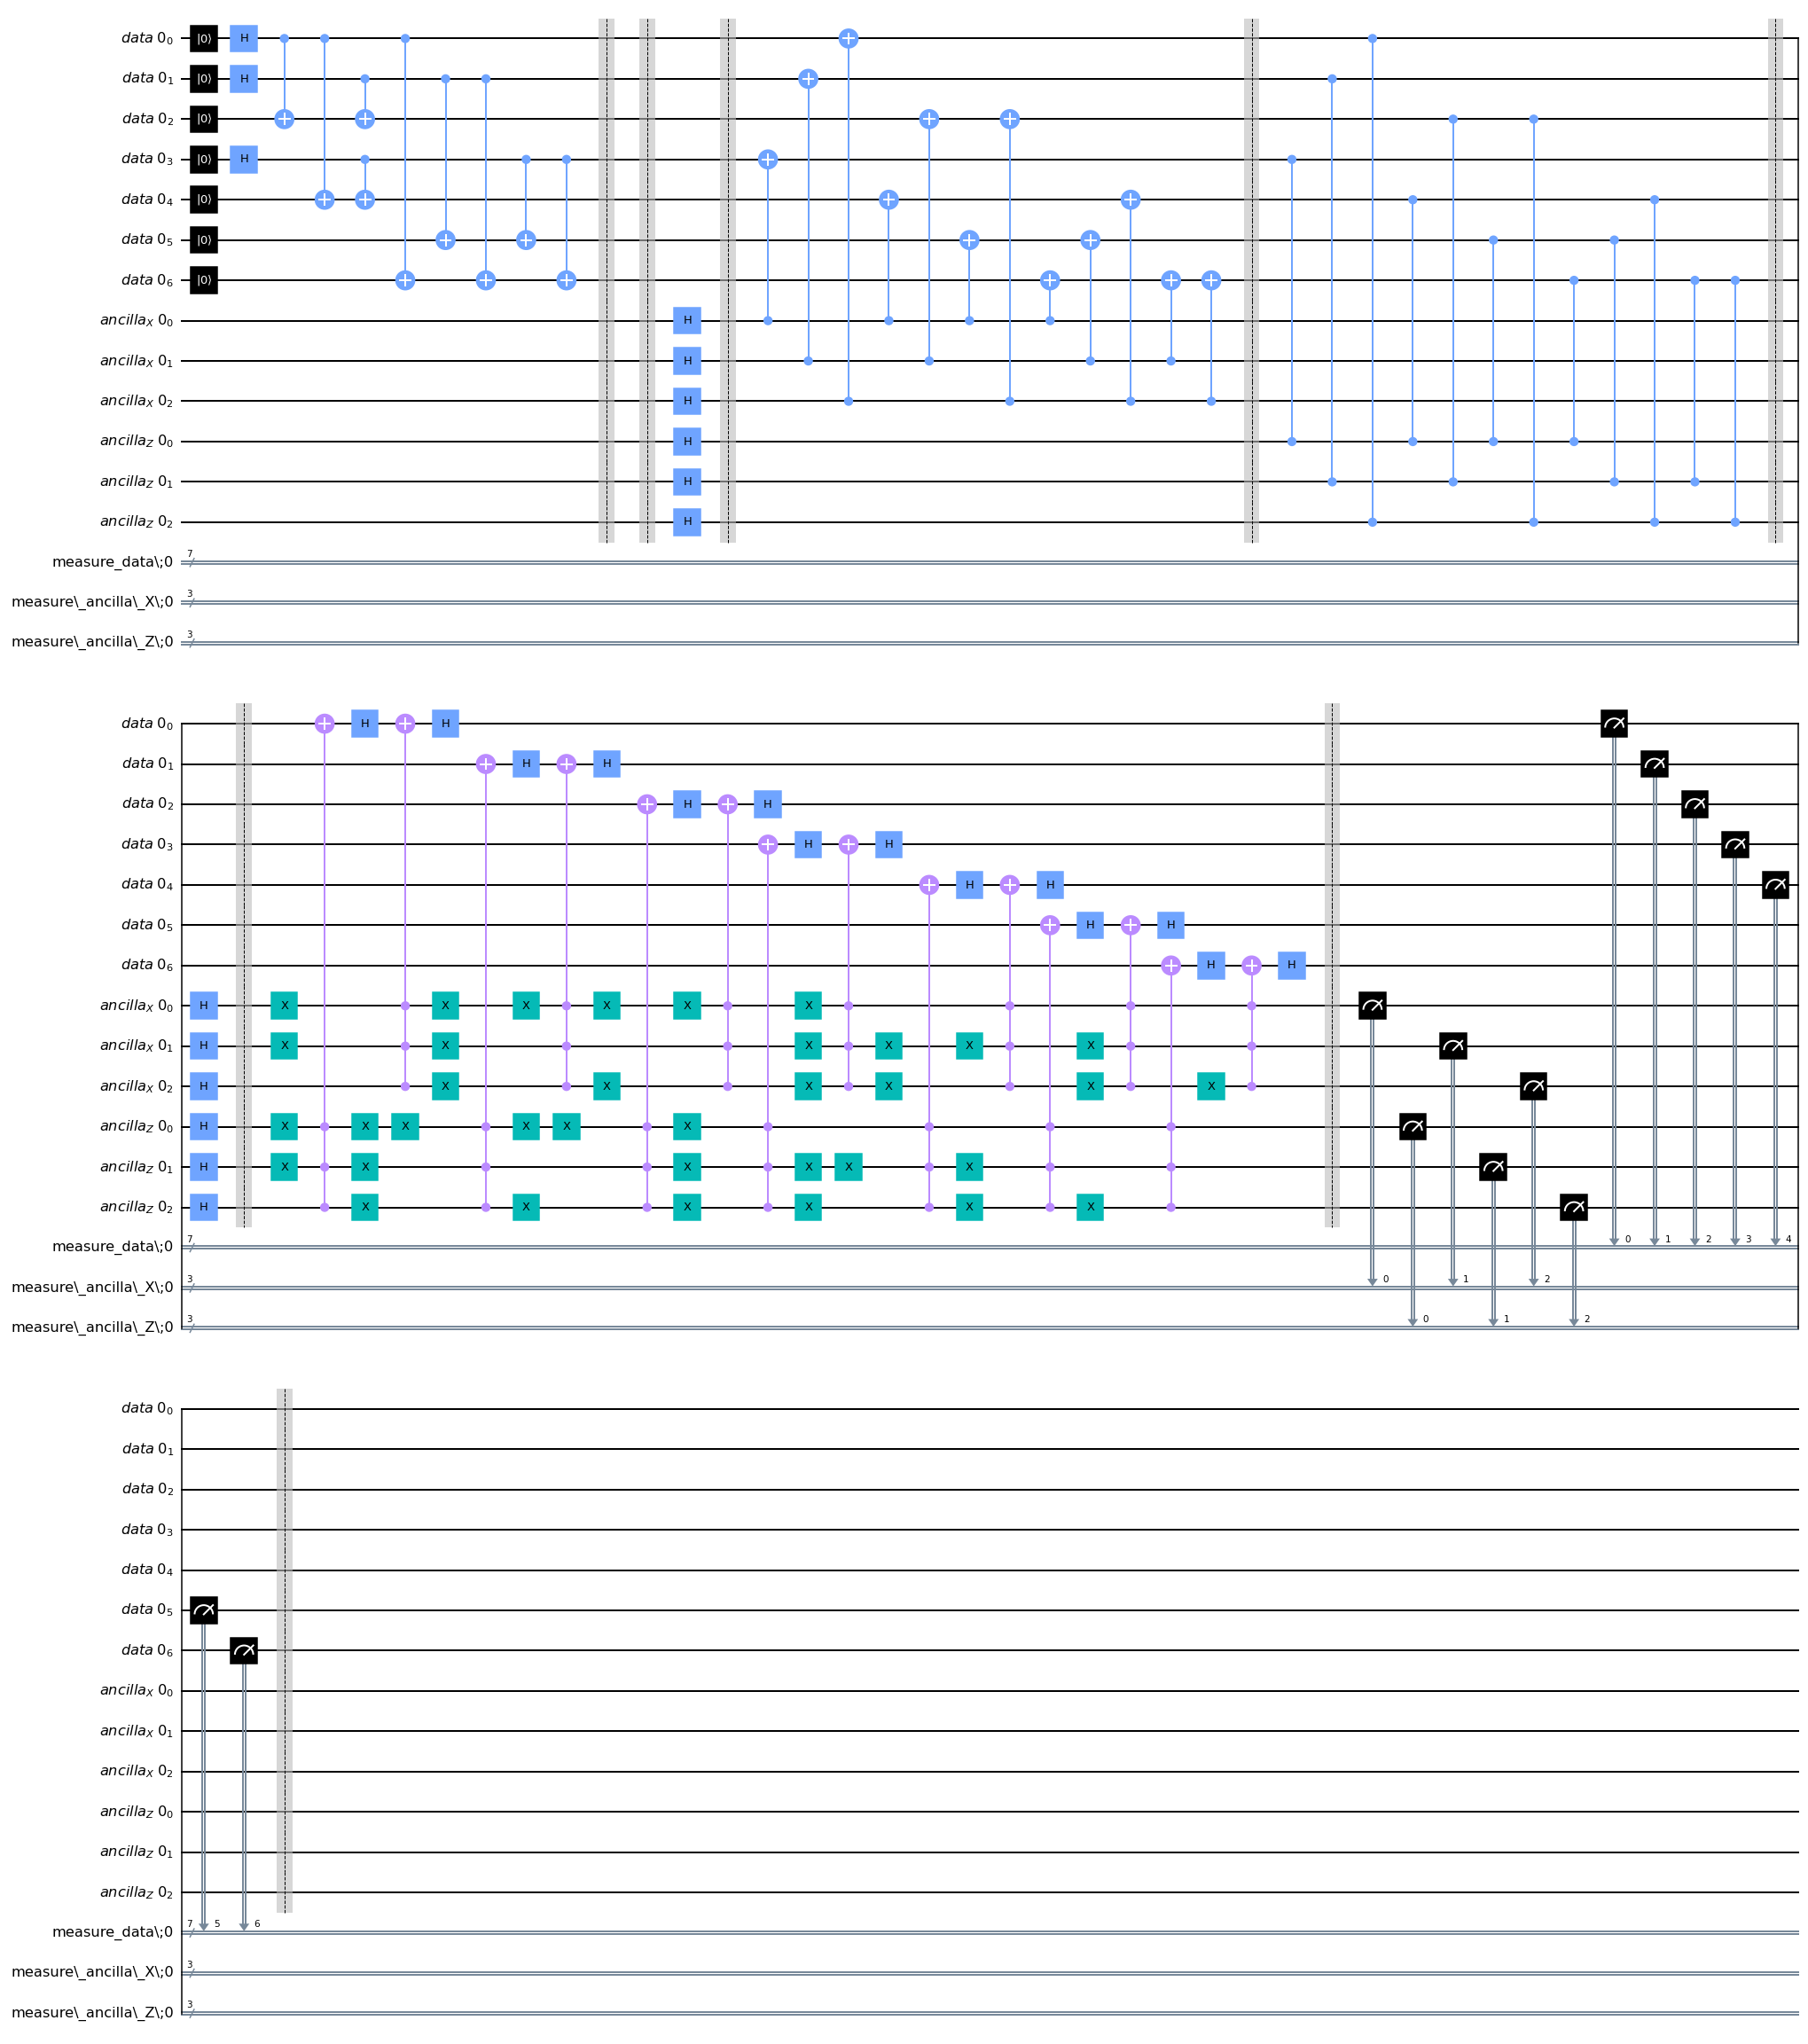

In [6]:
qubit.draw(output = 'mpl', filename = 'Steane_code_error_correction_circuit.jpg', fold = 40)

Draw transpiled circuit

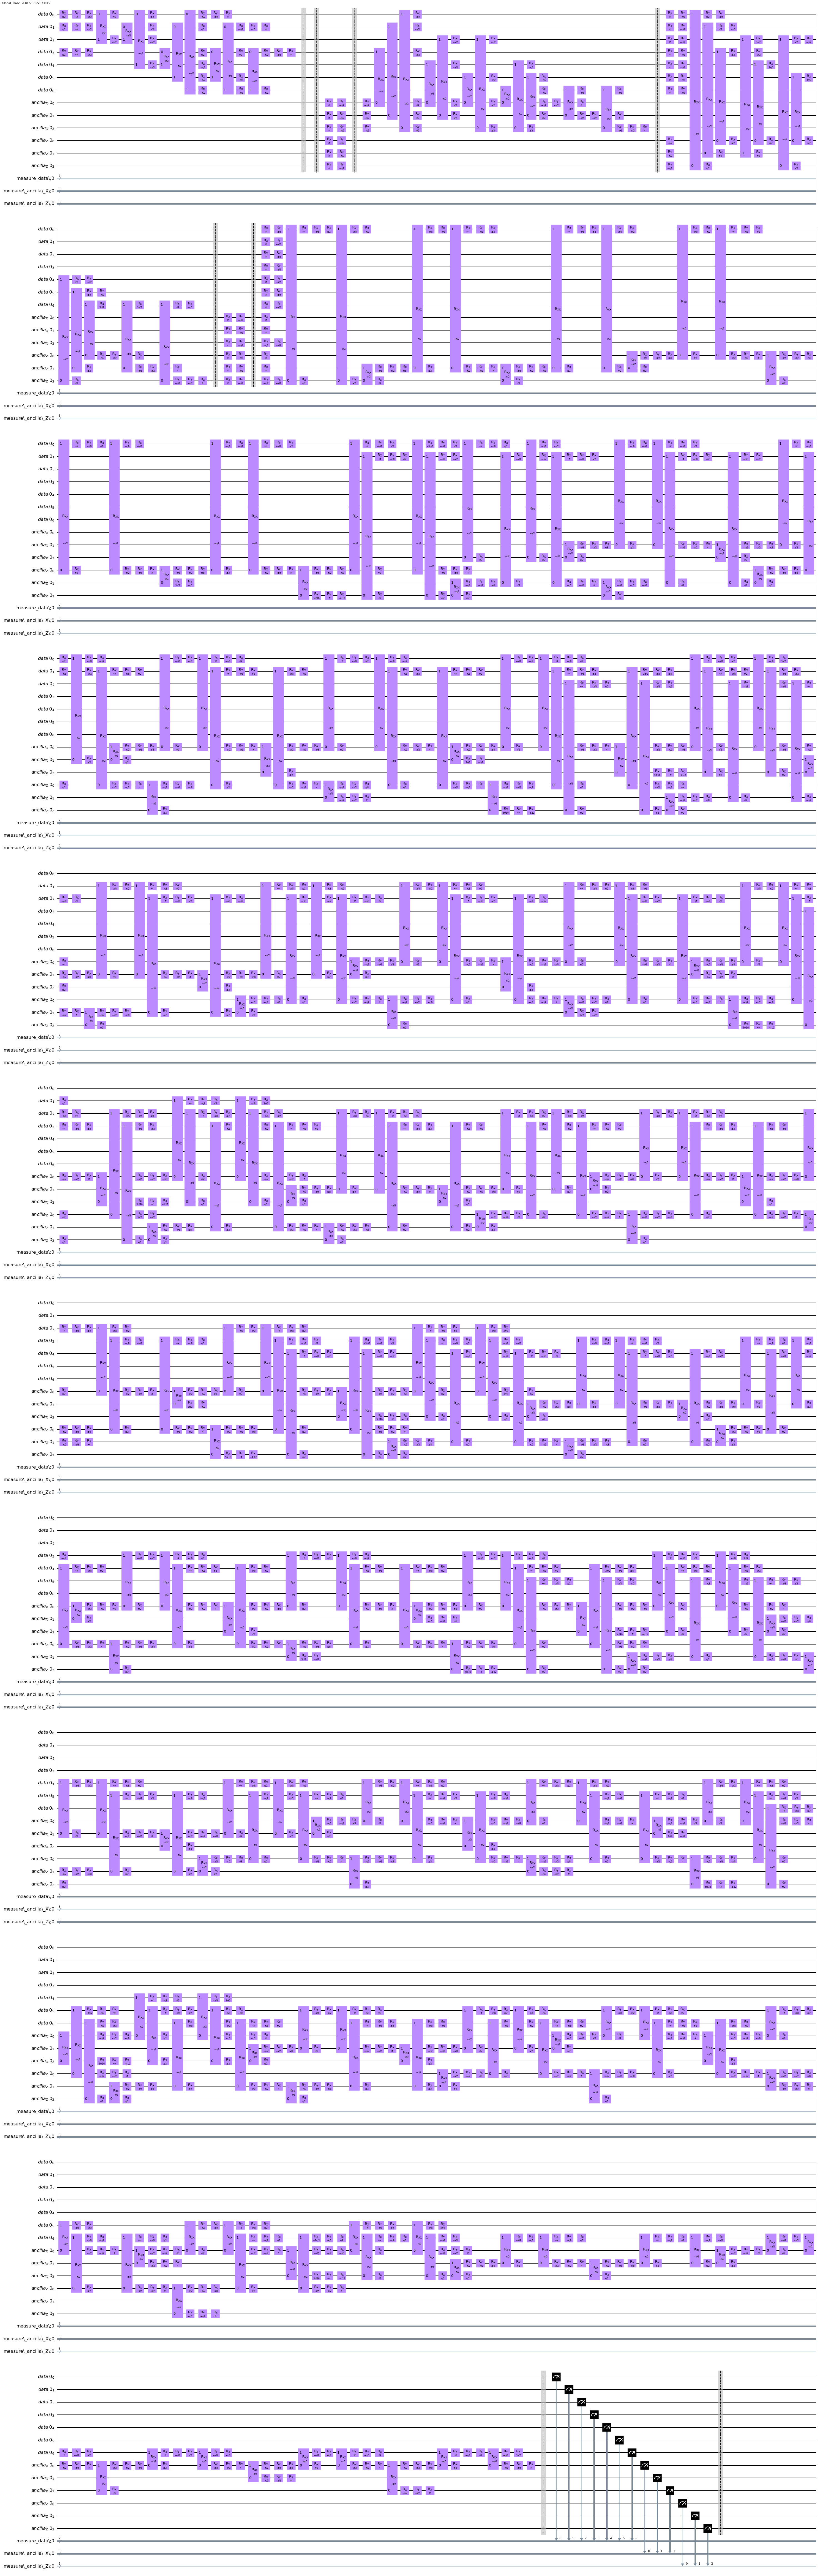

In [7]:
qt.draw(output = 'mpl', filename = 'Steane_code_error_correction_circuit_transpiled.jpg', fold = 60)